In [ ]:
import os
os.chdir('../')

In [47]:
import tensorflow as tf
from lib.model import dice
from lib import *
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import json
from glob import glob

In [6]:
# Load trained model
unet = tf.keras.models.load_model('models/model_unet.h5', custom_objects={'dice' : dice})

In [11]:
#reading dataframe. template will be fixed and df_val will be filled with prediction of trained model
df_val = pd.read_csv('data/pred_val_template.csv')
df_pred = pd.read_csv('data/pred_val_template.csv')

In [19]:
# Getting list of validation images and masks
val_images = df_val['img_id'].apply(lambda img_id : np.array(Image.open(f"data/val/images/{img_id:08}.png").convert('RGB')) / 255).to_list()
val_annotations = json.load(open(f"data/val/coco_annotations.json", "r"))
val_masks = [get_mask(img_id, val_annotations) for img_id in df_val['img_id']]

In [21]:
# Getting prediction of our validation images
pred = unet.predict(np.array(val_images))

7/7 [==============================] - 1s 147ms/step


In [44]:
#Filling the results file for validation and fixing df_val with ground truth
df_pred['rle_mask'] = [encode_rle(pred[i] > 0.5) for i in range(200)]
df_val['rle_mask'] = [encode_rle(val_masks[i]) for i in range(200)]

In [45]:
#Count the dice metric for ground truth and predictions
get_dice(df_val['rle_mask'].apply(decode_rle).to_list(),
         df_pred['rle_mask'].apply(decode_rle).to_list())

0.9552511269930446

In [46]:
#Saving the results
df_val.to_csv('data/pred_val_template.csv')
df_pred.to_csv('results/pred_val_submission.csv')

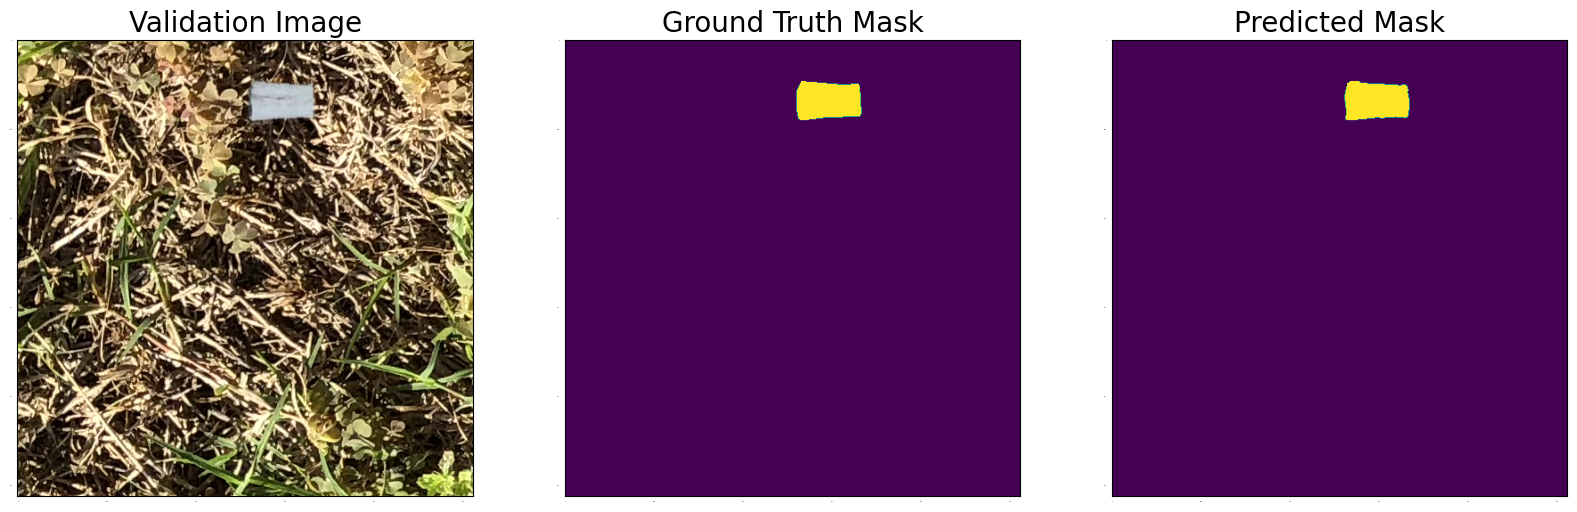

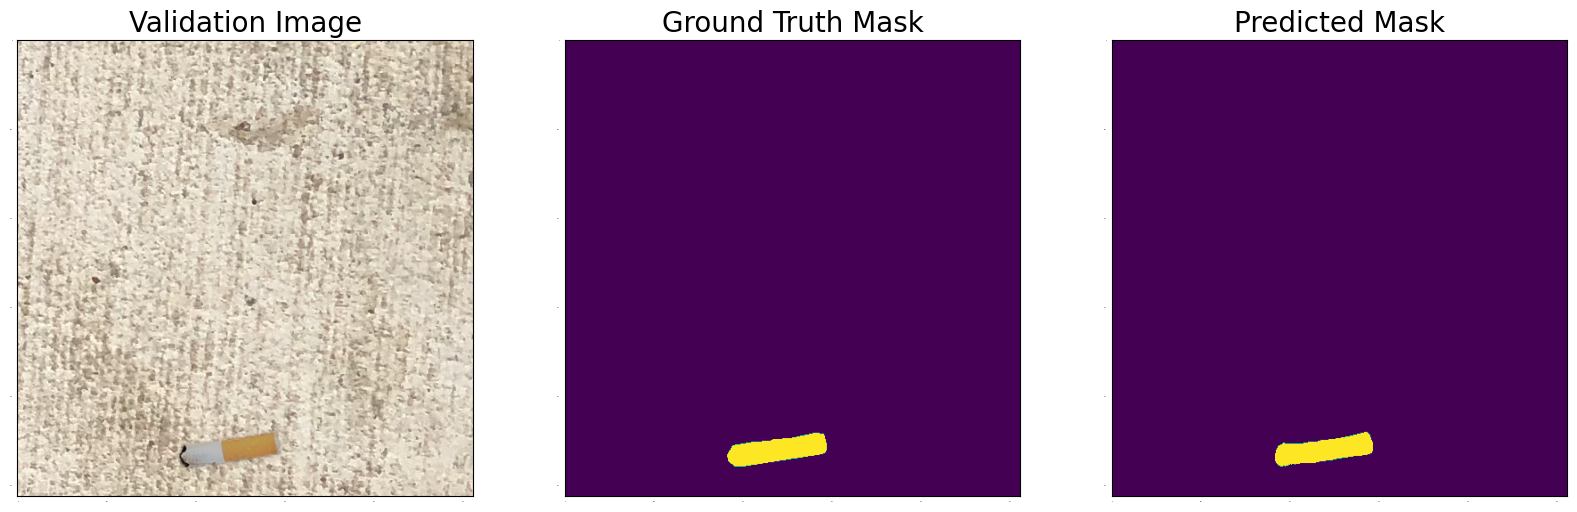

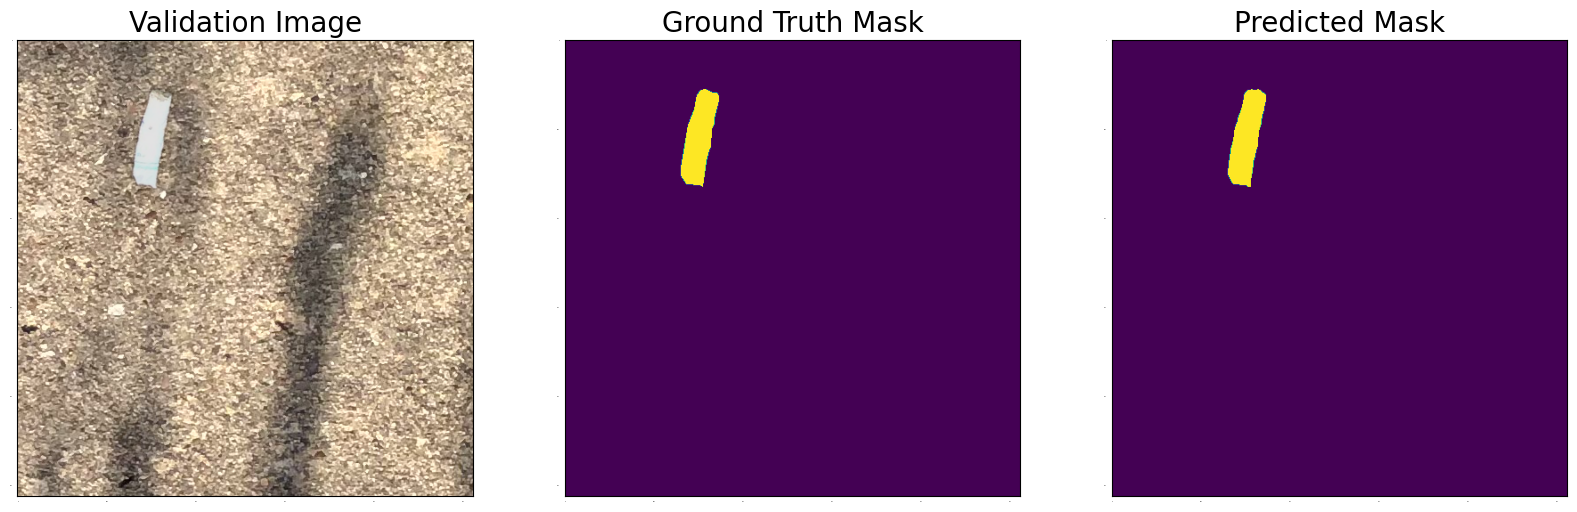

In [39]:
#Visualization of predicted results
n_images = 3
for _ in range(n_images):
    n = np.random.choice(range(200))
    fig, axs = plt.subplots(1,3,figsize=(20,30))
    axs[0].imshow(Image.fromarray((val_images[n] * 255).astype(np.uint8)))
    axs[1].imshow(Image.fromarray(((val_masks[n] > 0.5).reshape(512,512) * 255).astype(np.uint8)))
    axs[2].imshow(Image.fromarray(((pred[n] > 0.5).reshape(512,512) * 255).astype(np.uint8)))
    
    # Set title for each subplot
    axs[0].set_title("Validation Image", fontsize=20)
    axs[1].set_title("Ground Truth Mask", fontsize=20)
    axs[2].set_title("Predicted Mask", fontsize=20)
       
    # Remove spines from all subplots
    for ax in axs:
        ax.tick_params(axis='both', which='both', length=0, labelsize=0)
        
    plt.show()

In [72]:
#Generation html page for real_data

#Getting paths to the images from real test
real_names = sorted(glob('data/real_test/*'))

#Getting list of normalized images
real_images = [np.array(Image.open(name)) / 255 for name in real_names]

#Prediction of model
real_preds = unet.predict(np.array(real_images))

#Getting masks from prediction
real_masks = [((pred > 0.5).reshape(512,512) * 255).astype(np.uint8) for pred in real_preds]

#Construction of html with results
_ = get_html(real_names, real_masks, path_to_save="results/real_data")

1/1 [==============================] - 0s 33ms/step
